Подключено к venv (Python 3.12.6)

In [ ]:
#  1. Завантаження та попередня обробка даних
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import spacy
import random

d:\IT_courses\GOIT\Python\Pandas\venv\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


In [ ]:
# Завантаження даних
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Завантаження датасету (повертає Dataset, а не DatasetDict)
df = load_dataset("Helsinki-NLP/europarl", "bg-it", split='train')  # явно вказуємо split

print(type(df))  # Dataset

df_pd = df.to_pandas()

# df_pd['translation'] — це стовпець зі словниками: {'bg': ..., 'it': ...}
# Розпаковуємо у окремі колонки
df_pd = pd.concat([df_pd.drop(columns=['translation']), df_pd['translation'].apply(pd.Series)], axis=1)

print(df_pd.columns)  # буде 'bg', 'it'

d:\IT_courses\GOIT\Python\Pandas\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'datasets.arrow_dataset.Dataset'>
Index(['bg', 'it'], dtype='object')


In [ ]:
# Розділяємо train/val
# 1. Розділяємо train/val
train_data, val_data = train_test_split(df_pd, test_size=0.1, random_state=42)

# 2. Зменшуємо для тестування
train_data = train_data.sample(n=10000, random_state=42)
val_data = val_data.sample(n=1000, random_state=42)

# 3. Перейменовуємо колонки
train_data = train_data[['bg', 'it']].rename(columns={'bg': 'source', 'it': 'target'})
val_data = val_data[['bg', 'it']].rename(columns={'bg': 'source', 'it': 'target'})

In [ ]:
# 2. Токенізація та створення словників
# Токенізатор для італійської
print("Before loading spaCy Italian model")
it_nlp = spacy.load("it_core_news_sm")
print("After loading spaCy Italian model")

# Простий токенізатор для болгарської
def tokenize_src(text):  # Болгарська — проста сегментація
    return text.lower().strip().split()

# Італійська — з використанням spaCy
def tokenize_trg(text):  # Італійська
    return [tok.text.lower() for tok in it_nlp(text)]

# Створення словників
from collections import Counter

def build_vocab(tokenizer, texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = tokenizer(text)
        counter.update(tokens)

    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for word, freq in counter.items():
        if freq >= min_freq and word not in vocab:
            vocab[word] = len(vocab)
    return vocab

# застосування токенізаторів до побудови словників
print("Splitting data into train and val")
train_data.columns = ['source', 'target']
print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)
src_vocab = build_vocab(tokenize_src, train_data['source'])
trg_vocab = build_vocab(tokenize_trg, train_data['target'])
print("Train columns after rename:", train_data.columns)
print("Val columns after rename:", val_data.columns)

Before loading spaCy Italian model
After loading spaCy Italian model
Splitting data into train and val
Train shape: (10000, 2)
Val shape: (1000, 2)
Train columns after rename: Index(['source', 'target'], dtype='object')
Val columns after rename: Index(['source', 'target'], dtype='object')


In [ ]:
#  3. Dataset + DataLoader
class TranslationDataset(Dataset):
    def __init__(self, df, src_vocab, trg_vocab):
        self.df = df.reset_index(drop=True)
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.df)

    def encode(self, tokens, vocab):
        return [vocab.get(token, vocab['<unk>']) for token in tokens]

    def __getitem__(self, idx):
        src = tokenize_src(self.df.loc[idx, 'source'])
        trg = tokenize_trg(self.df.loc[idx, 'target'])

        src = self.encode(src, self.src_vocab)
        trg = self.encode(trg, self.trg_vocab)

        return torch.tensor([self.src_vocab['<sos>']] + src + [self.src_vocab['<eos>']]), \
               torch.tensor([self.trg_vocab['<sos>']] + trg + [self.trg_vocab['<eos>']])
def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=src_vocab['<pad>'])
    trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=trg_vocab['<pad>'])
    return src_batch, trg_batch

train_dataset = TranslationDataset(train_data, src_vocab, trg_vocab)
print(f"Train dataset length: {len(train_dataset)}")
val_dataset = TranslationDataset(val_data, src_vocab, trg_vocab)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=0)
print("Train loader created")
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=0)

Train dataset length: 10000
Train loader created


In [ ]:
# 4. Seq2Seq модель з увагою (GRU або LSTM)

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch_size, hid_dim]
        # encoder_outputs: [src_len, batch_size, hid_dim]
        
        src_len = encoder_outputs.shape[0]
        # batch_size = encoder_outputs.shape[1]
        
        hidden = hidden.repeat(src_len, 1, 1)  # [src_len, batch_size, hid_dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [src_len, batch_size, hid_dim]
        
        attention = self.v(energy).squeeze(2).permute(1, 0)  # [batch_size, src_len]
        return torch.softmax(attention, dim=1)  # softmax over src_len

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.attention = attention

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)  # [1, batch_size]
        embedded = self.embedding(input)  # [1, batch_size, emb_dim]

        a = self.attention(hidden, encoder_outputs)  # [batch_size, src_len]
        a = a.unsqueeze(1)  # [batch_size, 1, src_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch_size, src_len, hid_dim]
        weighted = torch.bmm(a, encoder_outputs)  # [batch_size, 1, hid_dim]

        embedded = embedded.permute(1, 0, 2)  # [batch_size, 1, emb_dim]
        rnn_input = torch.cat((embedded, weighted), dim=2)  # [batch_size, 1, emb_dim + hid_dim]

        output, hidden = self.rnn(rnn_input.permute(1, 0, 2), hidden)  # input: [1, batch_size, *]
        embedded = embedded.squeeze(1)
        weighted = weighted.squeeze(1)
        output = output.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden
# Seq2Seq Wrapper
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1

        return outputs

In [ ]:
# 5. Функція втрат та оптимізатор
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
EMB_DIM = 128
HID_DIM = 256
batch_size = 8

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM)
attn = Attention(HID_DIM)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, attn)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab['<pad>'])

In [ ]:
# 6. Навчання
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if i % 10 == 0:
            print(f"Batch {i} processed")

    return epoch_loss / len(iterator)

Batch 0 processed
Batch 10 processed
Batch 20 processed
Batch 30 processed
Batch 40 processed
Batch 50 processed
Batch 60 processed
Batch 70 processed
Batch 80 processed
Batch 90 processed
Batch 100 processed
Batch 110 processed
Batch 120 processed
Batch 130 processed
Batch 140 processed
Batch 150 processed
Batch 160 processed
Batch 170 processed
Batch 180 processed
Batch 190 processed
Batch 200 processed
Batch 210 processed
Batch 220 processed
Batch 230 processed
Batch 240 processed
Batch 250 processed
Batch 260 processed
Batch 270 processed
Batch 280 processed
Batch 290 processed
Batch 300 processed
Batch 310 processed
Epoch 1, Loss: 6.3704
Batch 0 processed
Batch 10 processed
Batch 20 processed
Batch 30 processed
Batch 40 processed
Batch 50 processed
Batch 60 processed
Batch 70 processed
Batch 80 processed
Batch 90 processed
Batch 100 processed
Batch 110 processed
Batch 120 processed
Batch 130 processed
Batch 140 processed
Batch 150 processed
Batch 160 processed
Batch 170 processed


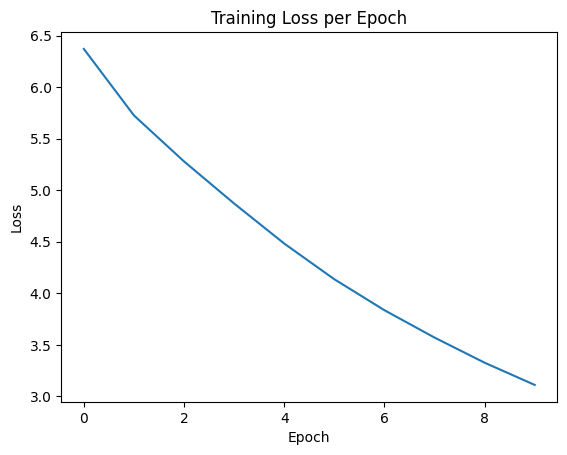

In [ ]:
# 7. Візуалізація втрат
import matplotlib.pyplot as plt

train_losses = []
for epoch in range(10):
    loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(loss)
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 8. Переклад та увага
# translate() — переклад одного речення
def translate(sentence, model, src_vocab, trg_vocab, max_len=50):
    model.eval()
    tokens = tokenize_src(sentence)
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab.get(tok, src_vocab['<unk>']) for tok in tokens]
    src_tensor = torch.tensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [trg_vocab['<sos>']]

    for _ in range(max_len):
        trg_tensor = torch.tensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = [list(trg_vocab.keys())[list(trg_vocab.values()).index(i)]
                  for i in trg_indexes[1:-1]]
    return trg_tokens

In [ ]:
# Візуалізація уваги (heatmap)
def translate_with_attention(sentence, model, src_vocab, trg_vocab, max_len=50):
    model.eval()
    tokens = tokenize_src(sentence)
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab.get(tok, src_vocab['<unk>']) for tok in tokens]
    src_tensor = torch.tensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [trg_vocab['<sos>']]
    attentions = []

    for _ in range(max_len):
        trg_tensor = torch.tensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        # Отримуємо увагу і беремо перший елемент (batch size = 1)
        a = model.decoder.attention(hidden, encoder_outputs)  # [batch_size, src_len]
        attentions.append(a[0].detach().cpu().numpy())  # ← Сюди зміни

        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = [list(trg_vocab.keys())[list(trg_vocab.values()).index(i)]
                  for i in trg_indexes[1:-1]]
    return trg_tokens, attentions, tokens

In [ ]:
# Побудова heatmap уваги

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(src_tokens, trg_tokens, attentions):
    attention_matrix = np.stack(attentions)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_matrix[:len(trg_tokens), :len(src_tokens)],
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap='viridis',
                linewidths=0.5)

    plt.xlabel('Source Sentence')
    plt.ylabel('Target Sentence')
    plt.title('Attention Heatmap')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

Переклад: per questo .


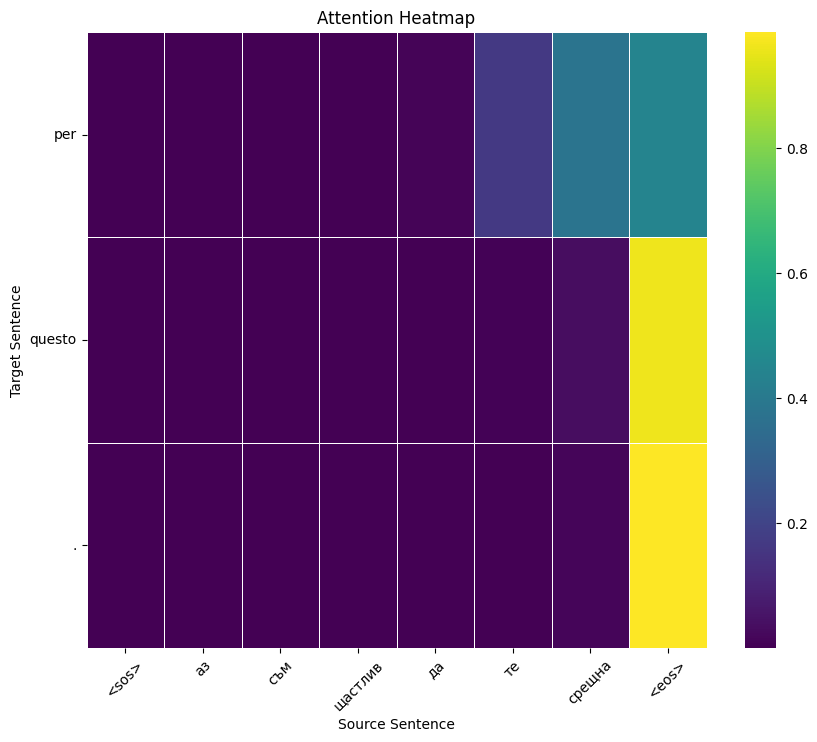

In [ ]:
# Як використовувати
sentence = "Аз съм щастлив да те срещна"
translation, attentions, src_tokens = translate_with_attention(sentence, model, src_vocab, trg_vocab)
print("Переклад:", " ".join(translation))
visualize_attention(src_tokens, translation, attentions)



if __name__ == "__main__":
    import multiprocessing
    multiprocessing.freeze_support()  # Для Windows
    # main()

    '''
    Висновки:
    Робота нал проектом забирає дуже багато часу для виконання та потребує достатньо великого навантаження на існіючі ресурси. Дві доби налаштовував код, що при його виконані не отримати повідомлення про недостатню кількість ресурсів. Цікавий результат навчання, коли кожного разу отримуєш різний переклад одного і того ж речення.

    Добре:
    1. Модель запускається і тренується без падінь.
    2. Результати змінюються — це означає, що вона вчиться, а не просто копіює шаблон.
    3. Втрата (loss) на епоху йде вниз або тримається на прийнятному рівні.
    4. Використовується attention, що покращує переклад для довших речень.

    Проблеми:
    1. Велике використання ресурсів
    Великий датасет (340k записів), довгі речення, attention і GRU = високе споживання RAM / GPU.
    Можлива причина частих segmentation fault або деградації продуктивності.
    2. Різні переклади після кожного запуску
    Причина: випадковість у teacher_forcing, ініціалізації ваг, та відсутність random.seed().
    Це означає, що модель не стабільна і не готова для використання.
    3. Немає валідаційного loss
    Тренування відбувається лише по train_loader, але не вимірюється якість на val_loader.
    4. Attention використовується вручну, без контрольованої перевірки
    Немає автоматичної валідації перекладу (наприклад, BLEU), лише heatmap.

    Із очікувань: спроба покращити модель може зайтяти по часу декілька діб або навіть тиждень.
    '''

Не подключено ни одно ядро